### Librairies & initialisation

In [1]:
######################
# librairies de base #
######################

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from OutilsP7 import *

##################
# SciKit - Learn #
##################

# Pre-Processing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.model_selection import ShuffleSplit, GridSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline

# Classification :
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

#####################
# Autres librairies #
#####################
import shap
import pickle
import joblib
from yellowbrick.model_selection import FeatureImportances
from mlflow.models.signature import infer_signature
import mlflow.sklearn

from imblearn.over_sampling import SMOTE

In [2]:
# On ingnorera les warning concernant les prochaines versions
def warn(*args, **kwargs):
    pass
warnings.warn = warn

In [3]:
path = "dataset/"

# <font color = 'red'> Exploration </font>

Il y a 9152465 valeurs manquantes sur 37516342 valeurs totales.
Le taux de remplissage est de : 75.6 %
Dimension du dataframe : (307511, 122)


,count,dtype,primary_key,nb_of_NaN,%_of_NaN,n_unique,unique_most_freq,num_mean,num_median,num_min,num_max,num_std
SK_ID_CURR,307511,int64,True,0,0.0,307511,NaN,278180.518577,278202.0,100002,456255,102790.175348
TARGET,307511,int64,False,0,0.0,2,0,0.080729,0.0,0,1,0.272419
NAME_CONTRACT_TYPE,307511,object,False,0,0.0,2,Cash loans,NaN,NaN,NaN,NaN,NaN
CODE_GENDER,307511,object,False,0,0.0,3,F,NaN,NaN,NaN,NaN,NaN
FLAG_OWN_CAR,307511,object,False,0,0.0,2,N,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
AMT_REQ_CREDIT_BUREAU_DAY,265992,float64,False,41519,13.5,9,0.0,0.007,0.0,0.0,9.0,0.110757
AMT_REQ_CREDIT_BUREAU_WEEK,265992,float64,False,41519,13.5,9,0.0,0.034362,0.0,0.0,8.0,0.204685
AMT_REQ_CREDIT_BUREAU_MON,265992,float64,False,41519,13.5,24,0.0,0.267395,0.0,0.0,27.0,0.916002
AMT_REQ_CREDIT_BUREAU_QRT,265992,float64,False,41519,13.5,11,0.0,0.265474,0.0,0.0,261.0,0.794056


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


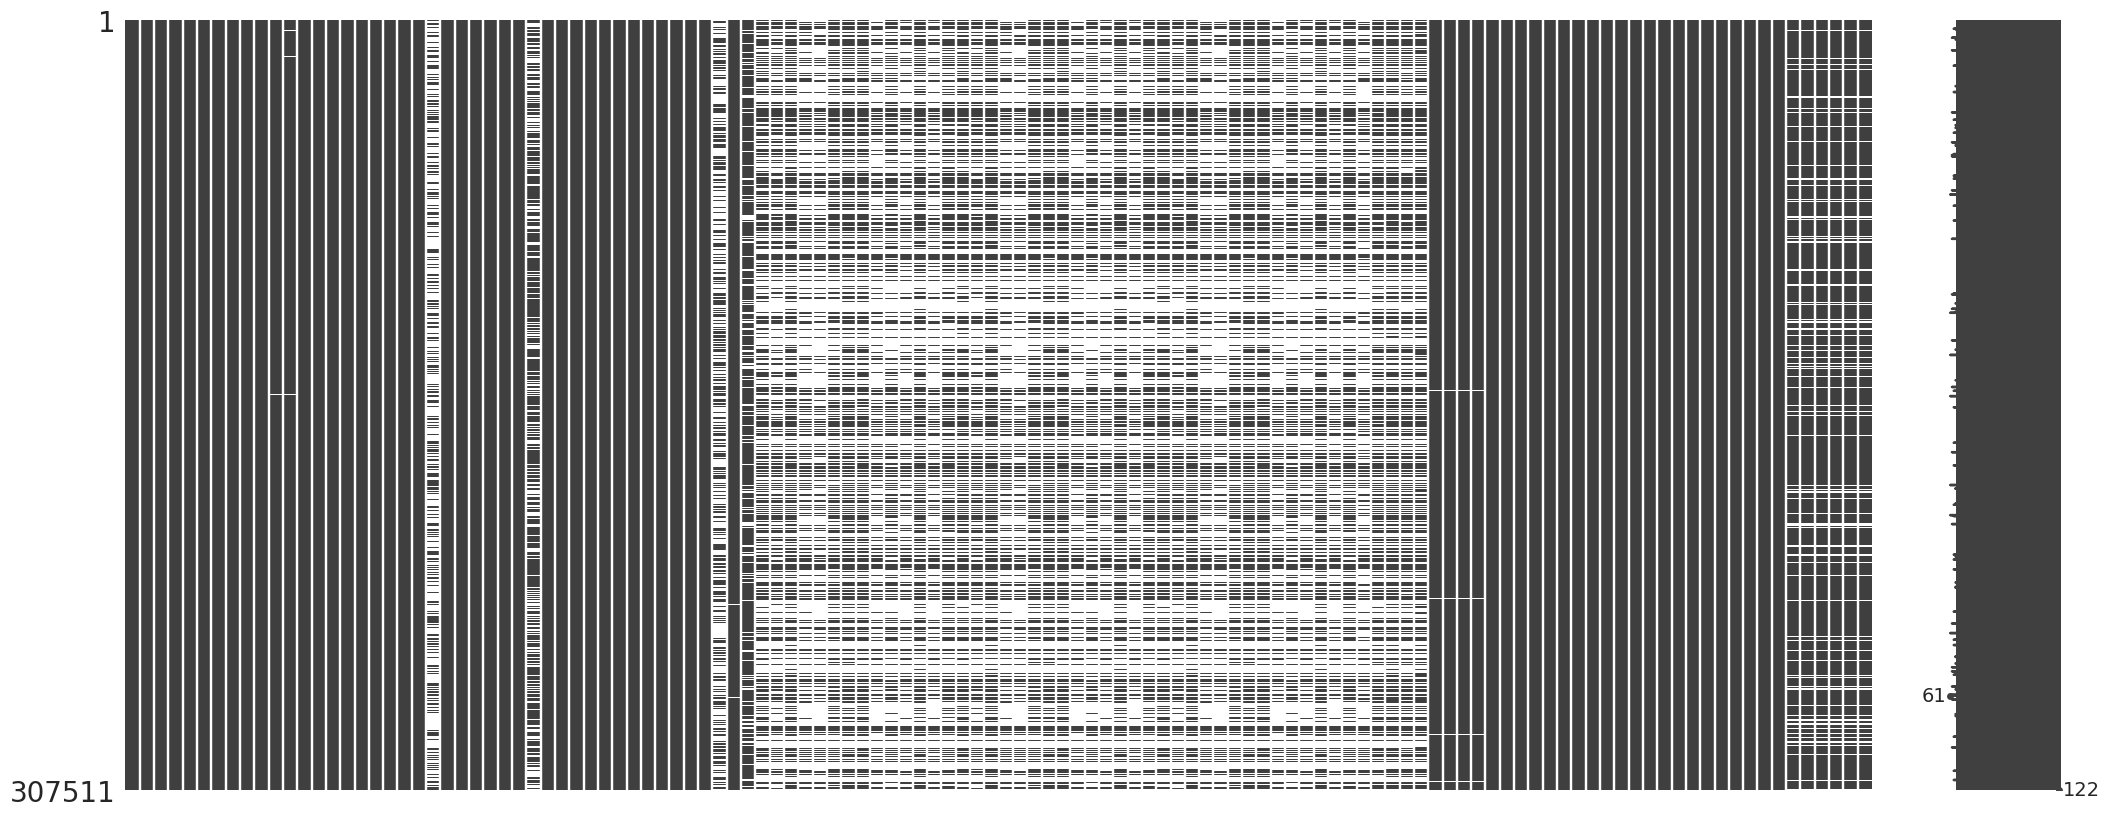

In [4]:
data = pd.read_csv(path + 'application_train.csv')
dataFrameInfos(data)

### Valeurs manquantes

Il y a 9152465 valeurs manquantes sur 37516342 valeurs totales.
Le taux de remplissage est de : 75.6 %
Dimension du dataframe : (307511, 122)


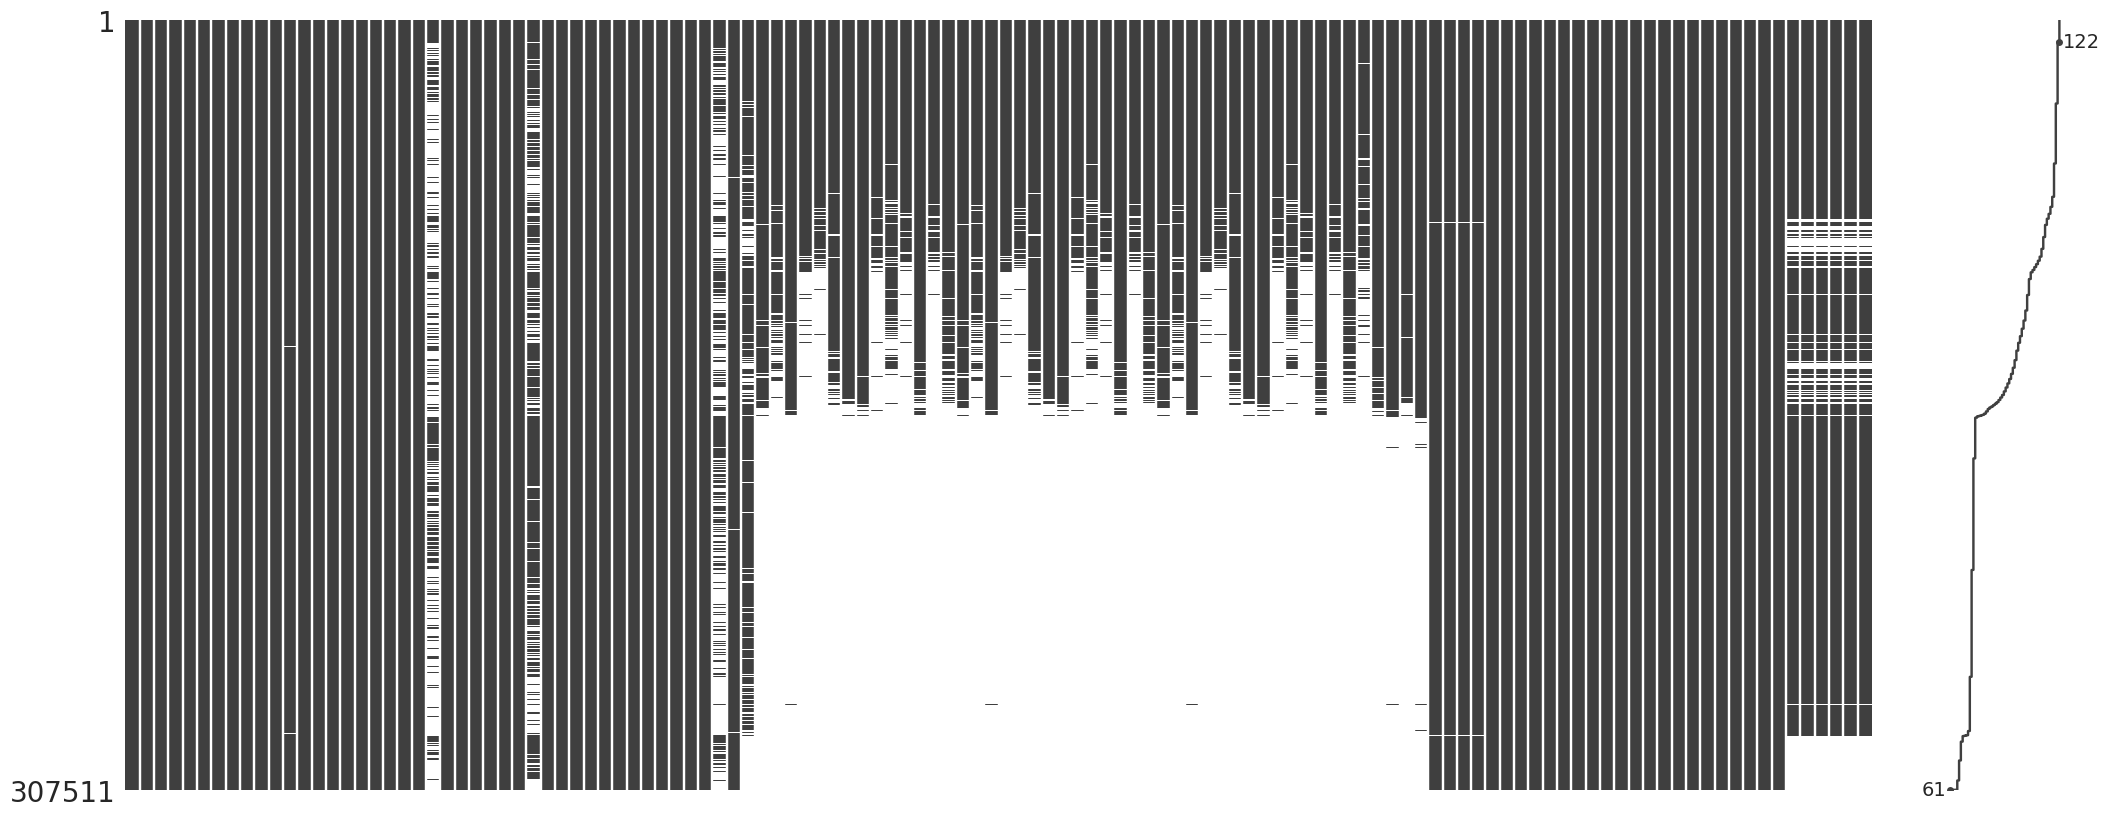

In [5]:
indexByNAN = data.isna().sum(axis = 1).sort_values().index
data = data.reindex(indexByNAN)
columnsInfos = dataFrameInfos(data)

In [6]:
# Supression des colonnes ave cplus de 10% de NaN
tooMuchNaN = columnsInfos.loc[columnsInfos['%_of_NaN'] > 10].index
trainingSet = data.drop(tooMuchNaN, axis = 1)

# Supression des lignes avec des NaN restants
trainingSet.dropna(axis = 0, inplace = True)

Text(0.5, 1.0, 'Répartition de la variable cible dans le dataset nettoyé.')

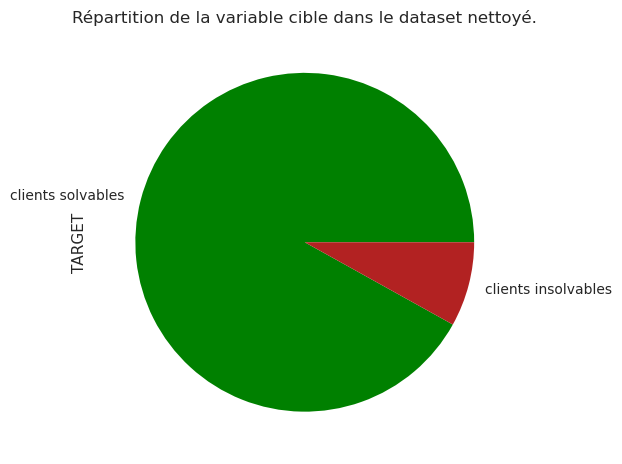

In [80]:
data['TARGET'].value_counts().plot.pie(colors = ['green','firebrick'], labels = ['clients solvables','clients insolvables'])
plt.title("Répartition de la variable cible dans le dataset nettoyé.")

## Préparation des datas pour api et dashboard

Il y a 1404419 valeurs manquantes sur 5898024 valeurs totales.
Le taux de remplissage est de : 76.18 %
Dimension du dataframe : (48744, 121)


,count,dtype,primary_key,nb_of_NaN,%_of_NaN,n_unique,unique_most_freq,num_mean,num_median,num_min,num_max,num_std
SK_ID_CURR,48744,int64,True,0,0.00,48744,NaN,277796.67635,277549.0,100001,456250,103169.547296
NAME_CONTRACT_TYPE,48744,object,False,0,0.00,2,Cash loans,NaN,NaN,NaN,NaN,NaN
CODE_GENDER,48744,object,False,0,0.00,2,F,NaN,NaN,NaN,NaN,NaN
FLAG_OWN_CAR,48744,object,False,0,0.00,2,N,NaN,NaN,NaN,NaN,NaN
FLAG_OWN_REALTY,48744,object,False,0,0.00,2,Y,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
AMT_REQ_CREDIT_BUREAU_DAY,42695,float64,False,6049,12.41,3,0.0,0.001803,0.0,0.0,2.0,0.046132
AMT_REQ_CREDIT_BUREAU_WEEK,42695,float64,False,6049,12.41,3,0.0,0.002787,0.0,0.0,2.0,0.054037
AMT_REQ_CREDIT_BUREAU_MON,42695,float64,False,6049,12.41,7,0.0,0.009299,0.0,0.0,6.0,0.110924
AMT_REQ_CREDIT_BUREAU_QRT,42695,float64,False,6049,12.41,8,0.0,0.546902,0.0,0.0,7.0,0.693305


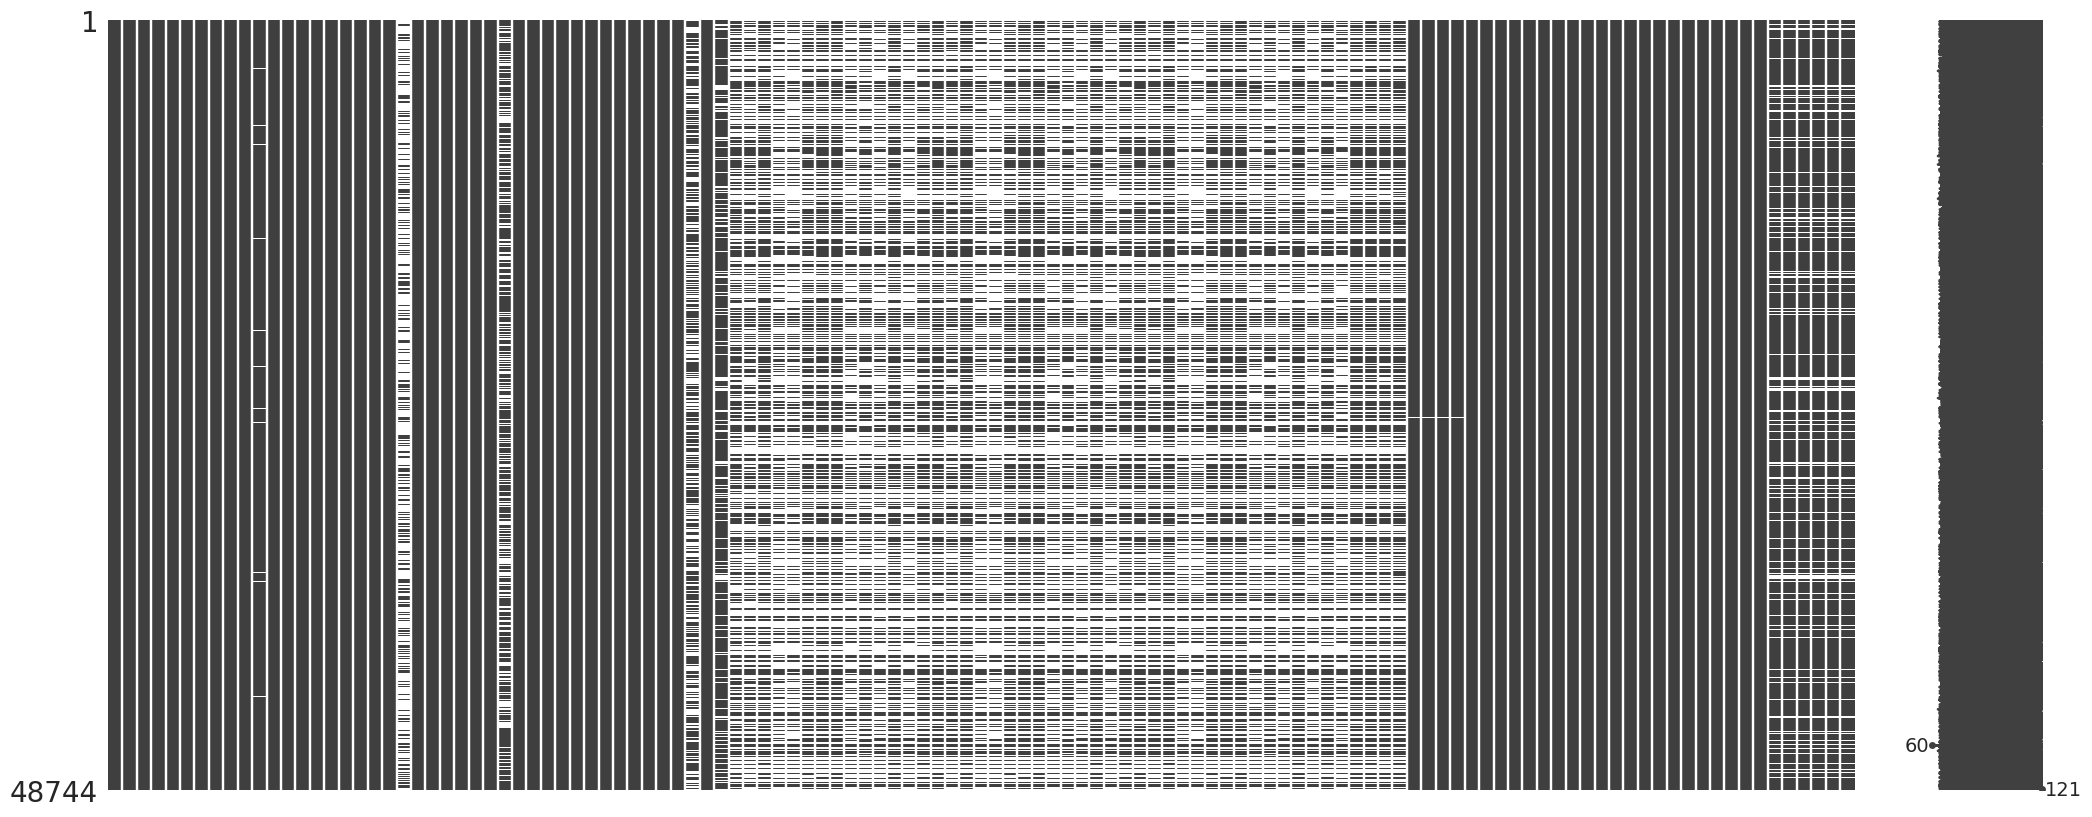

In [8]:
api_data = pd.read_csv(path + 'application_test.csv')
dataFrameInfos(api_data)

In [9]:
api_columns = tooMuchNaN.drop(['OWN_CAR_AGE','OCCUPATION_TYPE'])
api_data.drop(api_columns, axis = 1, inplace = True)
api_data.dropna(axis = 0, inplace = True)
api_data.to_csv('app/dataset/application_test.csv')

In [10]:
bureauCSV = pd.read_csv(path + 'bureau.csv')
bureauCSV = bureauCSV.loc[bureauCSV['SK_ID_CURR'].isin(api_data['SK_ID_CURR'].to_list()),:]
bureauCSV.drop(['SK_ID_BUREAU','CREDIT_CURRENCY','AMT_ANNUITY','AMT_CREDIT_MAX_OVERDUE'], axis = 1, inplace = True)
bureauCSV.to_csv('app/dataset/bureau.csv')

In [11]:
del bureauCSV
del api_data
del api_columns

In [12]:
trainingSet.shape

(304531, 65)

# <font color = 'red'> __Classification__ </font>
## <font color = 'green'> Preprocessing </font>
__Récupération des données__

In [13]:
# Séparation des variables cible et d'entrées.
X_data = trainingSet.drop(['TARGET','SK_ID_CURR'], axis = 1)
Y_data = trainingSet['TARGET']

# Récupération des informations du dataframe d'entrée
columnsInfos = dataFrameInfos(X_data, heatmap = False)

Il y a 0 valeurs manquantes sur 19185453 valeurs totales.
Le taux de remplissage est de : 100.0 %
Dimension du dataframe : (304531, 63)


__Transformation des datas d'entrée__

In [14]:
# Sélection des colonnes pour l'encodage et la normalisation
columnsScaler = columnsInfos.loc[columnsInfos['dtype'] == 'int64',:].index.to_list()
columnsScaler = columnsScaler + columnsInfos.loc[columnsInfos['dtype'] == 'float64',:].index.to_list()
columnsTargetEncoder = columnsInfos.loc[(columnsInfos['dtype'] == 'object')*(columnsInfos['n_unique'] > 10),:].index.to_list()
columnsOneHotEncoder = columnsInfos.loc[(columnsInfos['dtype'] == 'object')*(columnsInfos['n_unique'] <= 10),:].index.to_list()

# Montage du transformer
transformer = make_column_transformer((OneHotEncoder(handle_unknown = 'error', sparse = False),columnsOneHotEncoder),
                                      (TargetEncoder(),columnsTargetEncoder),
                                      (StandardScaler(),columnsScaler))

In [15]:
# Réglage du transformer et transformation des données
X_transformed = transformer.fit_transform(X_data, Y_data)

__Egalisation du dataset__
<br> Equilibrage des TARGET 0-1 pour eviter un modèle faussé.

X_aug.shape : (559728, 100)
X_aug.shape : (559728,) 




Text(0.5, 1.0, 'Répartition de la variable cible dans le dataset égalisé.')

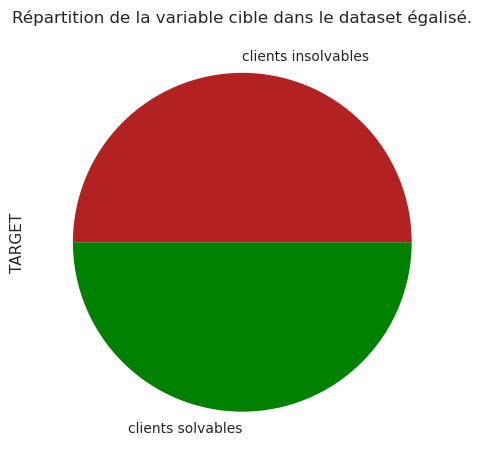

In [83]:
oversampler = SMOTE()
X_aug, Y_aug = oversampler.fit_resample(X_transformed, Y_data)

# Dimensions des données égalisées
print('X_aug.shape :', X_aug.shape)
print('X_aug.shape :', Y_aug.shape, '\n\n')

# Affichage de la répartition de la variable cible
Y_aug.value_counts().plot.pie(colors = ['firebrick','green'], labels = ['clients insolvables','clients solvables'])
plt.title("Répartition de la variable cible dans le dataset égalisé.")

## <font color = 'green'> Modélisation </font>

__Train-test-split__

In [19]:
cv = ShuffleSplit(5, test_size = 0.2, random_state = 5)
X_train, X_test, Y_train, Y_test = train_test_split(X_aug, Y_aug, test_size=0.7, random_state=42)

__Optimisation d'hyper-paramètres__

In [29]:
# Modèle
classifier = RandomForestClassifier()

# Paramètres candidats
param_grid = {'n_estimators' : [100,200],
              'min_samples_split' : [1,2,3],
              'min_samples_leaf' : [1,2],
              'criterion' : ['gini', cost_function, 'entropy', 'log_loss'],
              'max_depth' : [10]}

#param_grid = {'penalty' : ['l1','l2','elasticnet',None],
#              'fit_intercept' : [True, False],
#              'max_iter' : [500,800,1000,2000]}

# Grille de recherche
grid = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=cv,
                    n_jobs=12, scoring='f1',return_train_score=True)

In [30]:
# Optimisation des paramètres
grid.fit(X_train, Y_train)

# Récupération et sauvegarde du dataframe cv_results
pd.DataFrame(grid.cv_results_).to_csv('cv_results.csv')

In [36]:
# Récupération et sauvegarde du dataframe cv_results
pd.DataFrame(grid.cv_results_).to_csv('cv_results.csv')

In [31]:
# récupération du meilleur classifier et accélération du modèle
params = grid.best_params_
params['n_jobs'] = 12
classifier.set_params(**params)
print(params)

{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 200, 'n_jobs': 12}


__Entrainement Final__

In [18]:
# Augmentation du jeu d'entrainement (80 %)
X_train, X_test, Y_train, Y_test = train_test_split(X_aug, Y_aug, test_size=0.2, random_state=43)

In [19]:
# Entrainement
classifier.fit(X_train, Y_train)

NameError: name 'classifier' is not defined

In [34]:
print('ROC AUC :')
print("Train score :", np.round(roc_auc_score(Y_train, classifier.predict(X_train)),6))
print("Test  score :", np.round(roc_auc_score(Y_test, classifier.predict(X_test)),4))
print('F1 score :')
print("Train score :", np.round(f1_score(Y_train, classifier.predict(X_train)),6))
print("Test  score :", np.round(f1_score(Y_test, classifier.predict(X_test)),4))

ROC AUC :
Train score : 0.888323
Test  score : 0.886
F1 score :
Train score : 0.885595
Test  score : 0.883


In [35]:
# Montage du pipeline
pipe = Pipeline([('transformer',transformer),('classifier', classifier)])

# Sauvegarde du pipeline
model_bytes = pickle.dumps(pipe)
joblib.dump(model_bytes[:len(model_bytes)//2], filename = 'modelPart1.joblib', compress = 0)#('lzma', 9))
joblib.dump(model_bytes[len(model_bytes)//2:], filename = 'modelPart2.joblib', compress = 0)#('lzma', 9))

['modelPart2.joblib']

In [63]:
# jeu d'entrainement (20 %)
X_train, X_test, Y_train, Y_test = train_test_split(X_aug, Y_aug, test_size=0.8, random_state=43)

In [64]:
part1 = joblib.load('modelPart1.joblib')
part2 = joblib.load('modelPart2.joblib')
model_bytes = part1+part2

In [65]:
model = pickle.loads(model_bytes)
transformer = model['transformer']
features_names = transformer.transformers_[0][1].get_feature_names_out().tolist() + transformer.transformers_[1][2] + transformer.transformers_[2][2]

FeatureImportances(ax=<AxesSubplot:>,
                   estimator=RandomForestClassifier(max_depth=10,
                                                    min_samples_split=3,
                                                    n_estimators=200,
                                                    n_jobs=12))

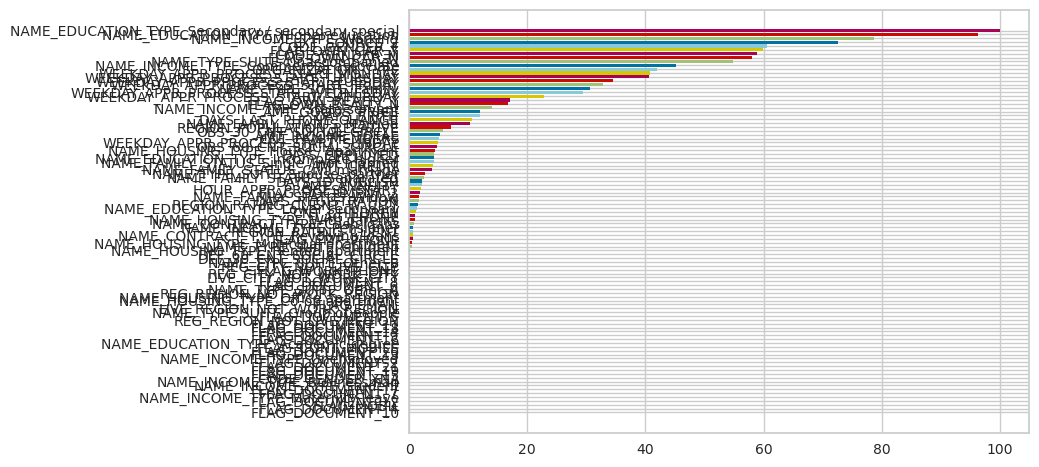

In [68]:
X_traindf = pd.DataFrame(X_train, columns = features_names)
viz = FeatureImportances(model['classifier'])
viz.fit(X_traindf)

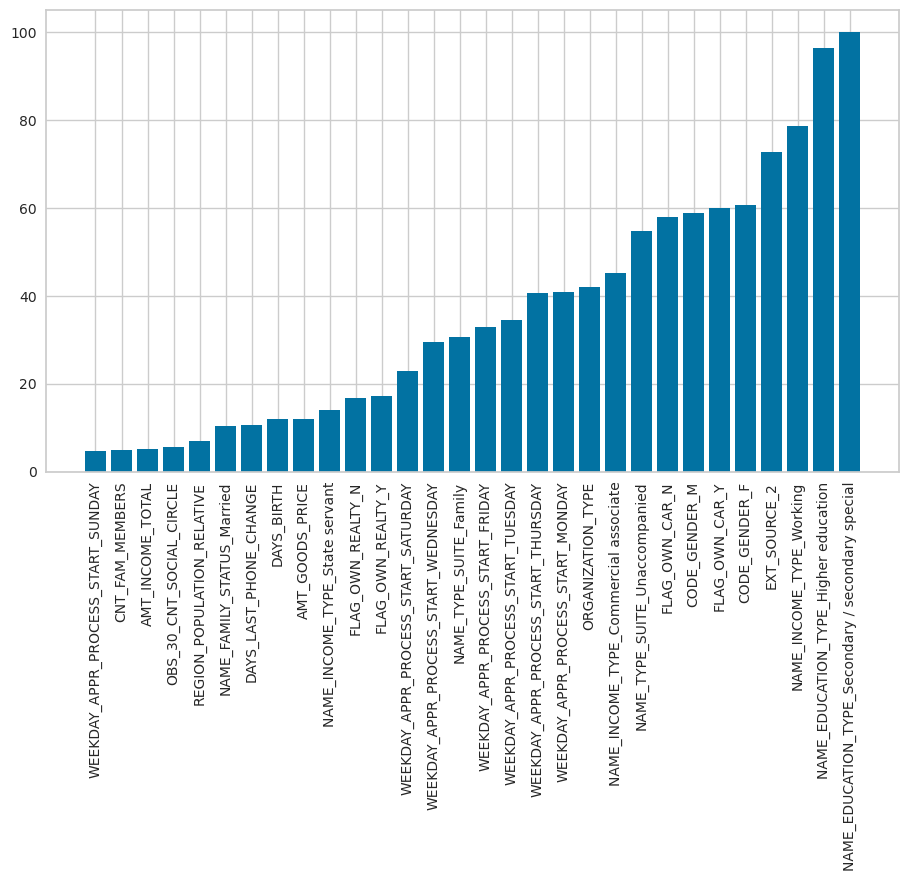

In [79]:
plt.figure(figsize = (11,6))
plt.bar(viz.features_[-30:], viz.feature_importances_[-30:])
plt.xticks(rotation = 90)
plt.show()